# 1. Introduction and General Information

In this project, we analyze the LastFM dataset released in the framework of HetRec 2011 (http://ir.ii.uam.es/hetrec2011). This dataset contains social networking, tagging, and music artist listening information from a set of 1892 users and 17632 artists. Different type of files are given, describing the interactions between user-user, user-artist or tags. Our aim is to create a reccomender system based on users' listening counts and then, if possible, improve it using the social network (trust preference network). The social network can bring useful information if it is based on users' musical tastes (users connect if they like same music) so we constructed a comparison users network to prove or confute the relationship between users.

In [2]:
%load_ext autoreload
%autoreload 1

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd
import os.path
import networkx as nx
from Dataset import Dataset
from plots import *

%matplotlib inline

In [3]:
# Define paths of the files
data_folder = os.path.join('.','data')
artists_path = os.path.join(data_folder,'artists.dat')
ratings_path = os.path.join(data_folder,'user_artists.dat')
friendship_path = os.path.join(data_folder,'user_friends.dat')
tags_path = os.path.join(data_folder,'tags.dat')
tags_assign_path = os.path.join(data_folder,'user_taggedartists-timestamps.dat')

artists = pd.read_csv(artists_path, sep='\t', header=0, index_col=0, skipinitialspace=True)
ratings = pd.read_csv(ratings_path, sep='\t', header=0, skipinitialspace=True)
tags = pd.read_csv(tags_path, sep='\t', header=0, index_col=0, skipinitialspace=True, encoding='latin1')
tags_assign = pd.read_csv(tags_assign_path, sep='\t', header=0, skipinitialspace=True)
user_user = pd.read_csv(friendship_path, sep='\t', header=0,  skipinitialspace=True)

# Data Exploration

In this section we analyze our dataset that has the following structure: for each user there is a list of his/her favorite artists, each listened artist has a listening record denoting the listening times; for each artist there is a list of his/her genre, which is a list of tags given by users that have ever listened to the artist. In addition for each user there is a list of his/her friends.

### Tag analysis

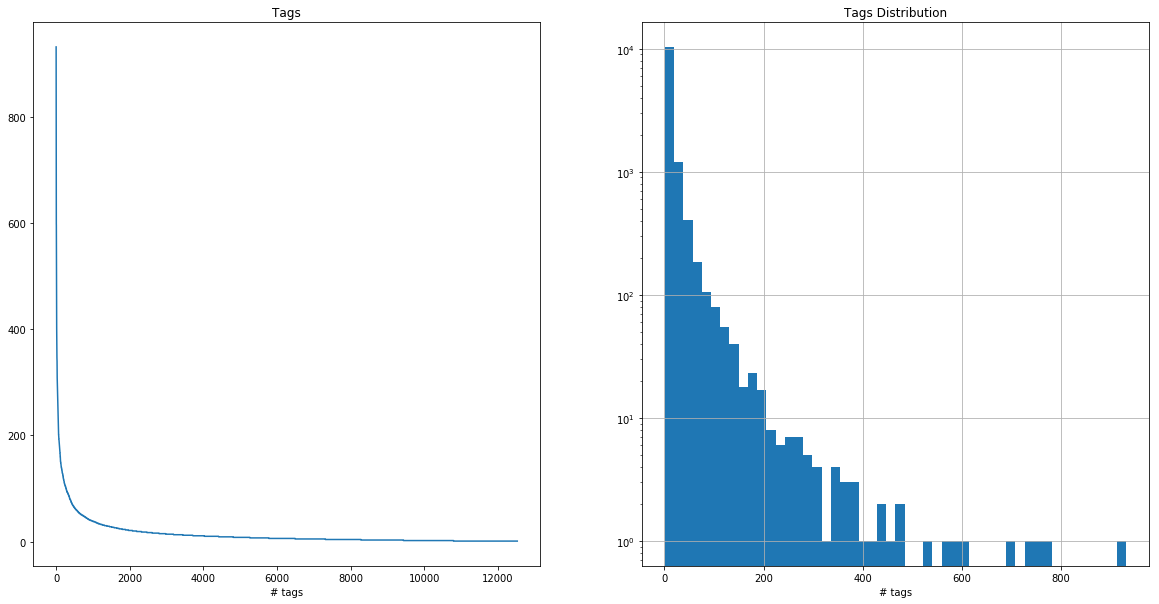

In [4]:
group = tags_assign[['artistID','tagID']].groupby(['artistID'])

group = group.size()
group.sort_values(ascending=False,inplace=True)

plot_tags_statistics(group)

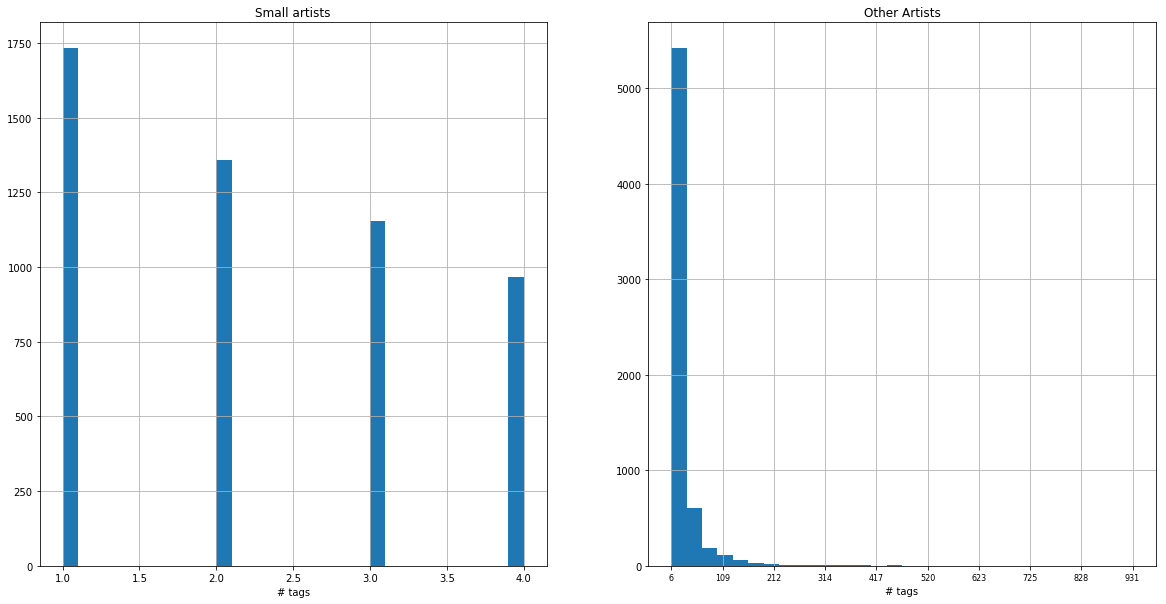

In [5]:
small = group.loc[group<5]
big = group.loc[group>5]

plot_separate_small_artist(small, big)

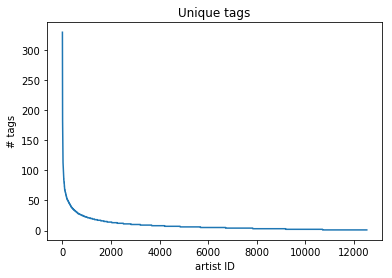

In [6]:
group = tags_assign[['artistID','tagID']].groupby(['artistID'])

group = group.nunique().tagID.sort_values(ascending=False)

plot_unique_tags(group)

From the above plot we can observe that for each artist we have a certain number of different tags but since LastFM tags are freeform a part of them can have the same meaning while written in different form, e.g., 90 -> 90' -> 90s or can have meaning that is identifiable only by the user itself.

### Listening count analysis

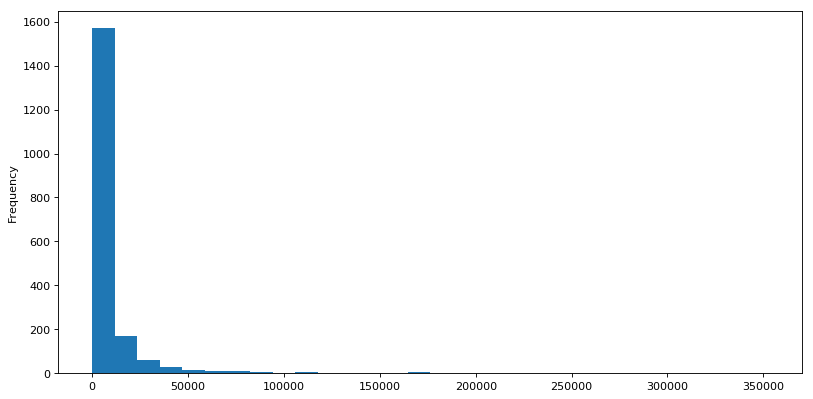

In [7]:
max_user_weight = ratings.groupby('userID').max()

plot_listenig_count_frequency(max_user_weight)

We can see from the plot above that most of the users have a maximum listening count of less than 50,000. We decided to remove users with weights much higher than the others trying to obtain a "smooth" distribution. We don't know the meaning of such high weights, but they are clearly outliers that could negatively affect our statistics.

In [8]:
print("The number of users with less than a maximum of 50,000 listening count:",\
      len(max_user_weight.loc[max_user_weight['weight']<=50000]))

percentage = len(max_user_weight.loc[max_user_weight['weight']<=50000])/ len(max_user_weight)*100
print("Percentage of total users:", \
     percentage ,"%")

The number of users with less than a maximum of 50,000 listening count: 1833
Percentage of total users: 96.8816067653277 %


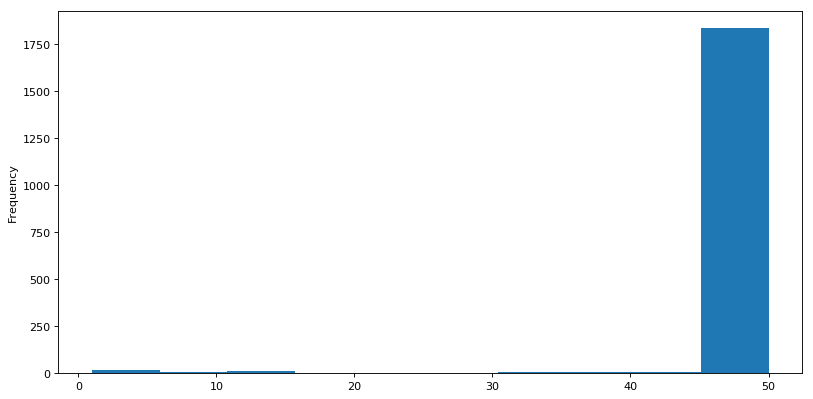

In [9]:
number_user_artist = ratings.groupby('userID').nunique().artistID.to_frame()

plot_artist_per_user(number_user_artist)

We can clearly see that most of the users have between 45 and 50 artists. We decided to remove the users who listened to less than 10 different artists. This kind of users could be new users or single-artist-listener which are not very useful to build a network for collaborative filtering.

In [11]:
users_to_drop = set()

# Group ratings based on users
group = ratings.groupby('userID')

# Drop users with too high max weight
data = group.max()
users_to_drop.update(data[data.weight > 50000].index)

# Drop users with few artists
data = group.nunique().artistID
users_to_drop.update(data[data < 10].index)

print(len(users_to_drop), ' users dropped')

76  users dropped


In [15]:
dd = Dataset()
ratings = dd.ratings
weights = ratings.weight

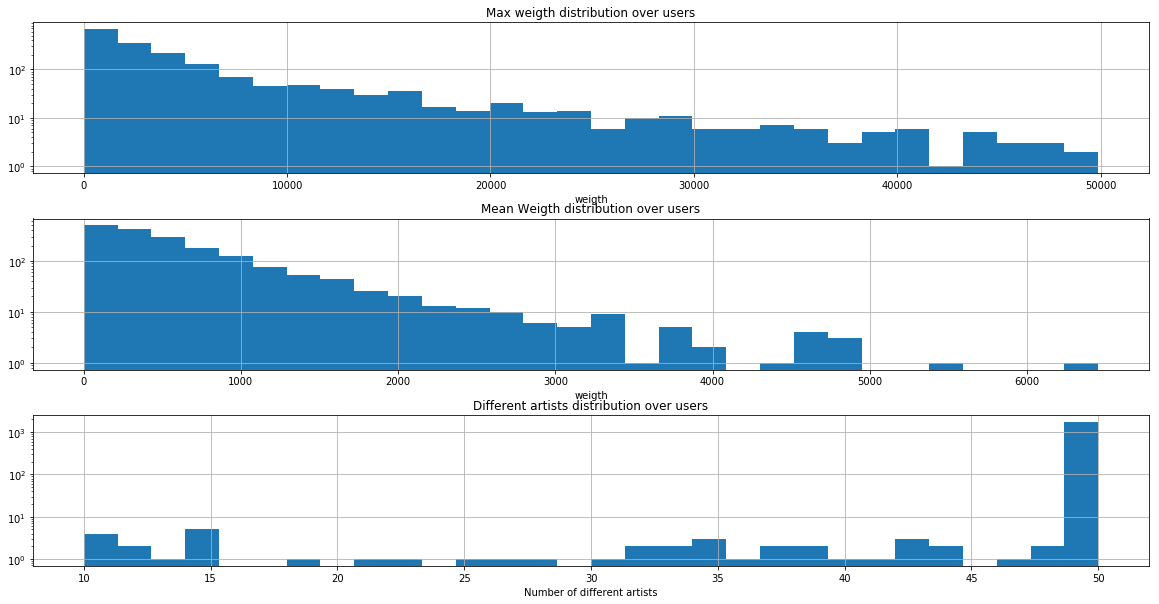

In [16]:
# Prune ratings
pruned = ratings.copy()
for u in users_to_drop:
    pruned = pruned[pruned.userID != u]
    
users = pruned.groupby('userID')

plot_statistics_on_user(users)

### Weight Normalization
We need to build a similarity graph for collaborative filtering. We need to understand which artists users listen to and not necessarely how much. Even though taking into account the absolute value of listening counts could have been a measure of how much we can trust a user preferences, we decided to normalize separately for each user in order to keep the weights simple and clear. In particular we model the normalized weight as the ratio the listening count and the biggest listening count for each user. Thus, all the weights of a user are less or equal to 1.

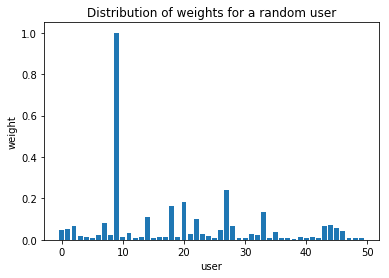

In [20]:
# Normalize weights for each user
users = pruned[['userID', 'weight']].groupby('userID')
tots = users.max().weight.to_dict()

normalized = pruned.copy()
normalized.weight = normalized.weight / [tots[i] for i in normalized.userID]

# Plot distribution of weights for a random user
user_weight_distribution(normalized, seed=1)

### User-User network

In this section we analyze the lastFm social network.

In [21]:
#G is the total graph with all users ,except the one already pruned, and multiple component
dd.prune_ratings()
G = nx.Graph(dd.build_friend_friend())

print('My network has {} nodes.'.format(len(G.nodes())))
print('My network has {} edges.'.format(G.size()))

24  users dropped in weights pruning
My network has 1868 nodes.
My network has 12439 edges.


In [11]:
nx.is_connected(G)

False

In [31]:
connected_components = nx.connected_components(G)
for i, subgraph in enumerate(sorted(connected_components, key = len, reverse=True)):
    print("Subgraph {} has {} nodes" .format(i, len(subgraph)))

Subgraph 0 has 1807 nodes
Subgraph 1 has 7 nodes
Subgraph 2 has 4 nodes
Subgraph 3 has 3 nodes
Subgraph 4 has 3 nodes
Subgraph 5 has 3 nodes
Subgraph 6 has 3 nodes
Subgraph 7 has 3 nodes
Subgraph 8 has 2 nodes
Subgraph 9 has 2 nodes
Subgraph 10 has 2 nodes
Subgraph 11 has 2 nodes
Subgraph 12 has 2 nodes
Subgraph 13 has 2 nodes
Subgraph 14 has 2 nodes
Subgraph 15 has 2 nodes
Subgraph 16 has 2 nodes
Subgraph 17 has 2 nodes
Subgraph 18 has 2 nodes
Subgraph 19 has 2 nodes
Subgraph 20 has 2 nodes
Subgraph 21 has 2 nodes
Subgraph 22 has 1 nodes
Subgraph 23 has 1 nodes
Subgraph 24 has 1 nodes
Subgraph 25 has 1 nodes
Subgraph 26 has 1 nodes
Subgraph 27 has 1 nodes
Subgraph 28 has 1 nodes


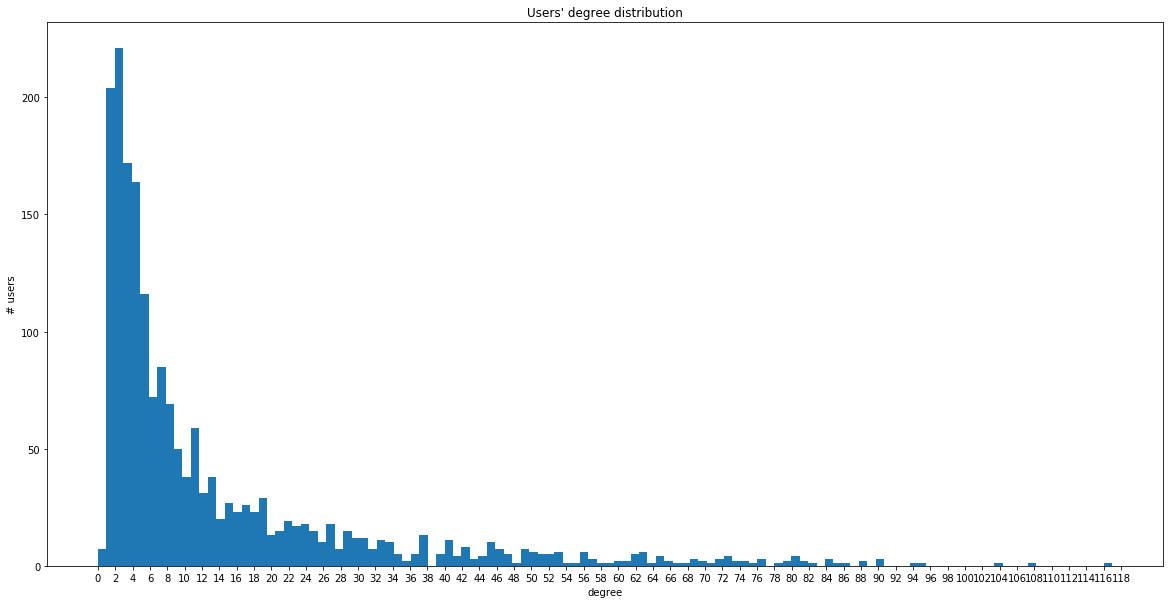

In [13]:
degree_distribution(G.degree())

The User social network graph is composed of 29 disconnected subgraphs. Fortunately most of the user (~ 97.5 %) are inside one subgraph, so we can discard all the others in order to have a connected graph.

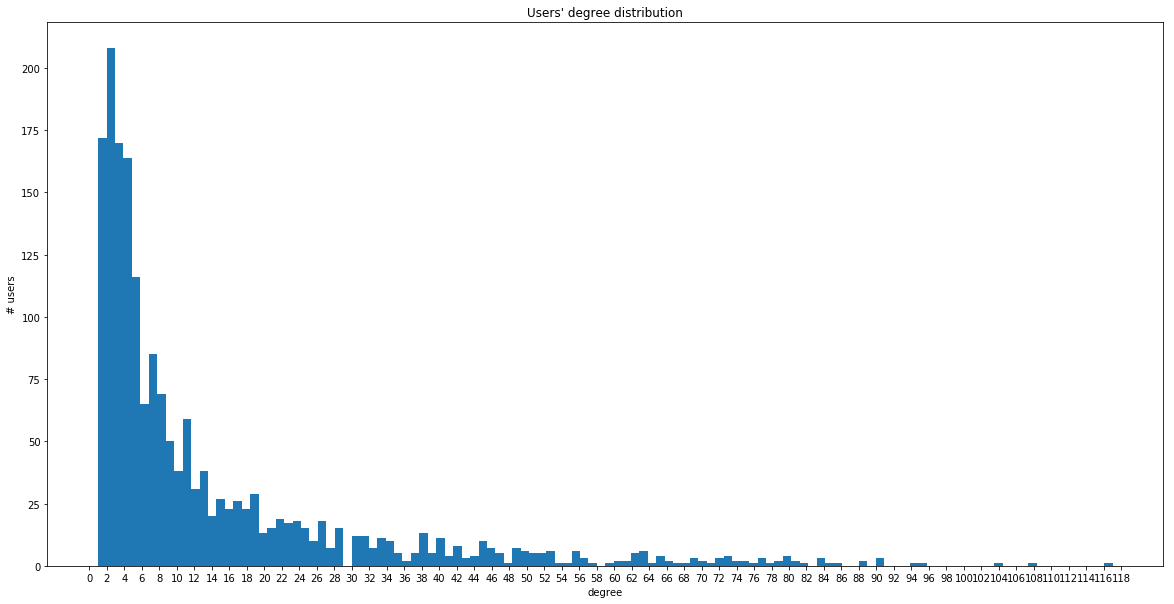

My network has 1807 nodes.
My network has 12386 edges.


In [14]:
graphs = list(nx.connected_component_subgraphs(G))
#giant component is the graph which contains most of the users
giant_component = graphs[0]

degree_distribution(giant_component.degree())

print('My network has {} nodes.'.format(len(giant_component.nodes())))
print('My network has {} edges.'.format(giant_component.size()))

As we can observe the degree distribution is mostly unchanged, we only have a little decrease of the number of user with very small connections since the subgraphs we deleted were composed of few users.

# Artist Similiraty Graph

# User Network Building

These are the steps we followed to build the user-user comparison network:
* Take the artist similarity graph and connect user to artist through the normalized listening .


* For each user consider all the possible 3-hop paths $u_i \rightarrow a_k \rightarrow a_l \rightarrow u_j$ where the connections $u_i \rightarrow a_k$ and $a_l \rightarrow u_j$ are weighted with the respective normalized weight (call them $C_{ik}$ and $C_{jl}$) while the weight between the two artist is given by the similiraty graph (call it $S_{kl}$).


* Add an edge between each pair $u_i$ and $u_j$ with a weight equal to: $F_{ij} = \sum\limits_{k,l \in \Omega} S_{kl}\min\{C_{ik}, C_{jl}\}$ where $\Omega$ is the set of all artist similar pair connected to user i and j
